Word 2 Vec LOTR
=============



In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import glob
import codecs
import nltk
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
import re
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/Users/kdalwani/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Download the data from the source website if necessary.

In [156]:
book_filenames = sorted(glob.glob("lotr/*.txt"))
print (book_filenames)


['lotr/1.txt', 'lotr/2.txt', 'lotr/3.txt']


Read the data into a string.

In [157]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/kdalwani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kdalwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [158]:
import pdb
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def read_data(book_filename):
  print("Reading '{0}'...".format(book_filename)) 
  
  with codecs.open(book_filename, "r", "utf-8") as book_file:
      corpus_raw = book_file.read()
      print()
      return corpus_raw
#       raw_sentences = tokenizer.tokenize(corpus_raw)
#       tokens.extend(raw_sentences.strip().split())
        
corpus_raw = u""
for file_path in book_filenames:
    corpus_raw += (read_data(file_path))
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print('Data size %d' % len(corpus_raw))

Reading 'lotr/1.txt'...

Corpus is now 995927 characters long
Data size 995927
Reading 'lotr/2.txt'...

Corpus is now 1814128 characters long
Data size 1814128
Reading 'lotr/3.txt'...

Corpus is now 2524734 characters long
Data size 2524734


Build the dictionary and replace rare words with UNK token.

In [159]:
raw_sentences = tokenizer.tokenize(corpus_raw)


In [210]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return [word.lower() for word in words]  

In [211]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [206]:
len(sentences)


32696

In [212]:
sentences[0]

[u'john',
 u'ronald',
 u'reuel',
 u'tolkien',
 u'the',
 u'lord',
 u'of',
 u'the',
 u'rings',
 u'the',
 u'fellowship',
 u'of',
 u'the',
 u'ring',
 u'j',
 u'r',
 u'r',
 u'tolkien',
 u'e',
 u'text',
 u'greylib',
 u'contents',
 u'foreword',
 u'prologue']

In [9]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))
filtered_words = [word.lower() for word in sentences if word.lower() not in stopwords_set]

In [165]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 485,086 tokens


In [10]:
words = filtered_words

In [11]:
words[0:10]

[u'john',
 u'ronald',
 u'reuel',
 u'tolkien',
 u'lord',
 u'rings',
 u'fellowship',
 u'ring',
 u'j',
 u'r']

In [12]:
type(stopwords.words('english'))

list

In [13]:
print("The book corpus contains {0:,} tokens".format(len(sentences)))

print("The book corpus (with stopwords removed) contains {0:,} tokens".format(len(filtered_words)))

The book corpus contains 485,086 tokens
The book corpus (with stopwords removed) contains 229,606 tokens


In [14]:
vocabulary_size = 12000
words = filtered_words
def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:15])
print('Sample data', data[:10])
print('Total Dictionary count:', len(dictionary))
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 491], (u'said', 4111), (u'frodo', 1991), (u'sam', 1290), (u'came', 1256), (u'great', 1197), (u'come', 1174), (u'could', 1169), (u'long', 1150), (u'would', 1146), (u'like', 1124), (u'gandalf', 1123), (u'one', 1070), (u'go', 1044), (u'back', 968)]
Sample data [5777, 5969, 5649, 3998, 78, 614, 2268, 54, 6347, 587]
Total Dictionary count: 12000


Function to generate a training batch for the skip-gram model.

In [17]:
dictionary['precious']

326

In [18]:
data_index = 0
import pdb
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
       
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)   
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:9]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: [u'john', u'ronald', u'reuel', u'tolkien', u'lord', u'rings', u'fellowship', u'ring', u'j']

with num_skips = 2 and skip_window = 1:
    batch: [u'ronald', u'ronald', u'reuel', u'reuel', u'tolkien', u'tolkien', u'lord', u'lord']
    labels: [u'john', u'reuel', u'ronald', u'tolkien', u'lord', u'reuel', u'tolkien', u'rings']

with num_skips = 4 and skip_window = 2:
    batch: [u'reuel', u'reuel', u'reuel', u'reuel', u'tolkien', u'tolkien', u'tolkien', u'tolkien']
    labels: [u'tolkien', u'john', u'ronald', u'lord', u'ronald', u'rings', u'lord', u'reuel']


Train a skip-gram model.

In [94]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [95]:
num_steps = 150001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
##    import pdb
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 15000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
#         pdb.set_trace()
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
#         pdb.set_trace()
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 6.596784
Nearest to said: firmly, countrified, haw, swam, spending, song, events, hated,
Nearest to one: exhibited, life, cavernous, waterfalls, whiffling, amethyst, rebuild, guise,
Nearest to know: price, wonder, orderly, ladder, tidings, gloomy, shivery, players,
Nearest to day: roving, kindlings, hisself, sometimes, perplexities, room, depths, hedge,
Nearest to thought: sufficed, ground, surging, cheeked, growled, kneeling, daring, durst,
Nearest to suddenly: stubbed, baggage, spoke, meriadoc, lower, courage, attacked, kindly,
Nearest to side: lumps, pushes, girt, entrust, guilty, invitations, also, dusst,
Nearest to hand: revealing, shown, elf, scarf, line, shut, jogged, mistake,
Nearest to great: clever, delivered, subterranean, skilful, mentioned, timid, sooner, needle,
Nearest to lord: everlasting, strangers, smell, awine, faintly, revived, twin, referred,
Nearest to loo

In [21]:
len(reverse_dictionary)

12000

In [96]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

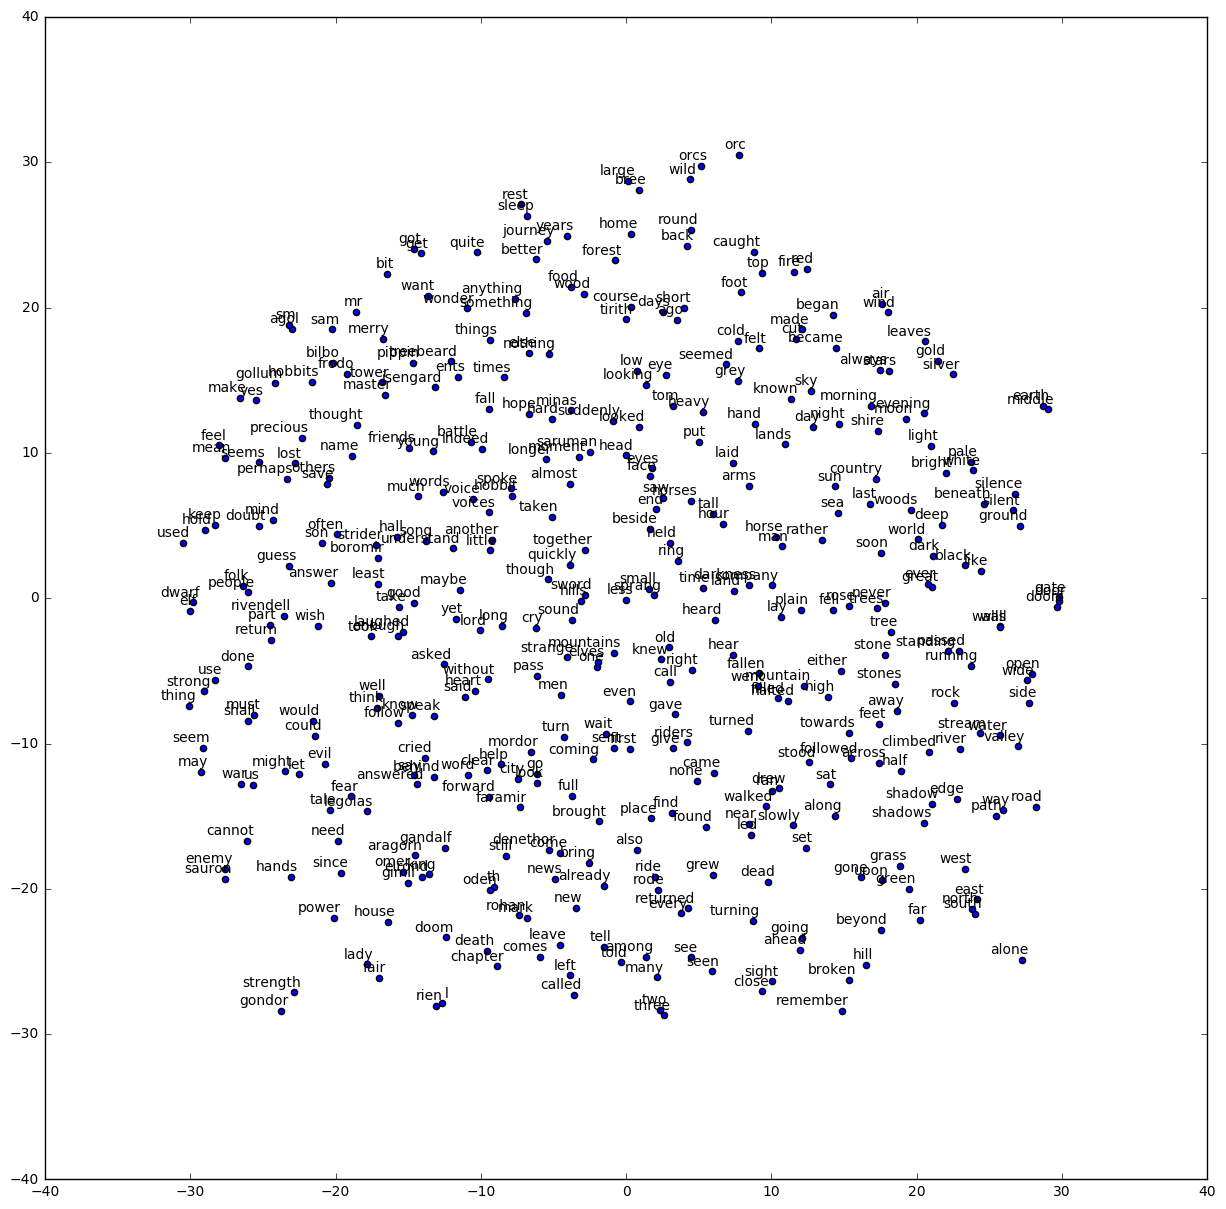

In [97]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    try:
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label.decode().encode('utf-8').strip(), xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    except Exception:
        print (label)
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Get most similar words

In [98]:
def get_similar_words(word_from):
    valid_word = dictionary[word_from]
    similarity = np.dot(final_embeddings[valid_word, np.newaxis] ,final_embeddings.T)
    top_k = 8 # number of nearest neighbors
    nearest = (-similarity[0, :]).argsort()[1:top_k+1]
    log = 'Nearest to %s:' % reverse_dictionary[valid_word]
    for k in range(top_k):
      close_word = reverse_dictionary[nearest[k]]
      log = '%s %s,' % (log, close_word)
    print(log)


In [101]:
get_similar_words('precious')

Nearest to precious: foundation, splendidly, slowcoach, methedras, wretch, perhaps, intolerable, conspirators,


---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [166]:
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [213]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
# num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 2

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [214]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
#     workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [215]:
len(sentences)

32696

In [216]:
thrones2vec.build_vocab(sentences)


In [217]:
print("Word2Vec vocabulary length:", len(thrones2vec.vocab))


Word2Vec vocabulary length: 6668


In [218]:
thrones2vec.train(sentences)


1729591

In [180]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = thrones2vec.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)


In [252]:
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
all_word_vectors_matrix_2d = tsne.fit_transform(thrones2vec.syn0[1:num_points+1, :])

In [222]:
# points = pd.DataFrame(
#     [
#         (word, coords[0], coords[1])
#         for word, coords in [
#             (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
#             for word in thrones2vec.vocab
#         ]
#     ],
#     columns=["word", "x", "y"]
# )

In [220]:
print (thrones2vec.syn0.shape)
print (type(thrones2vec.vocab))

(6668, 300)
<type 'dict'>


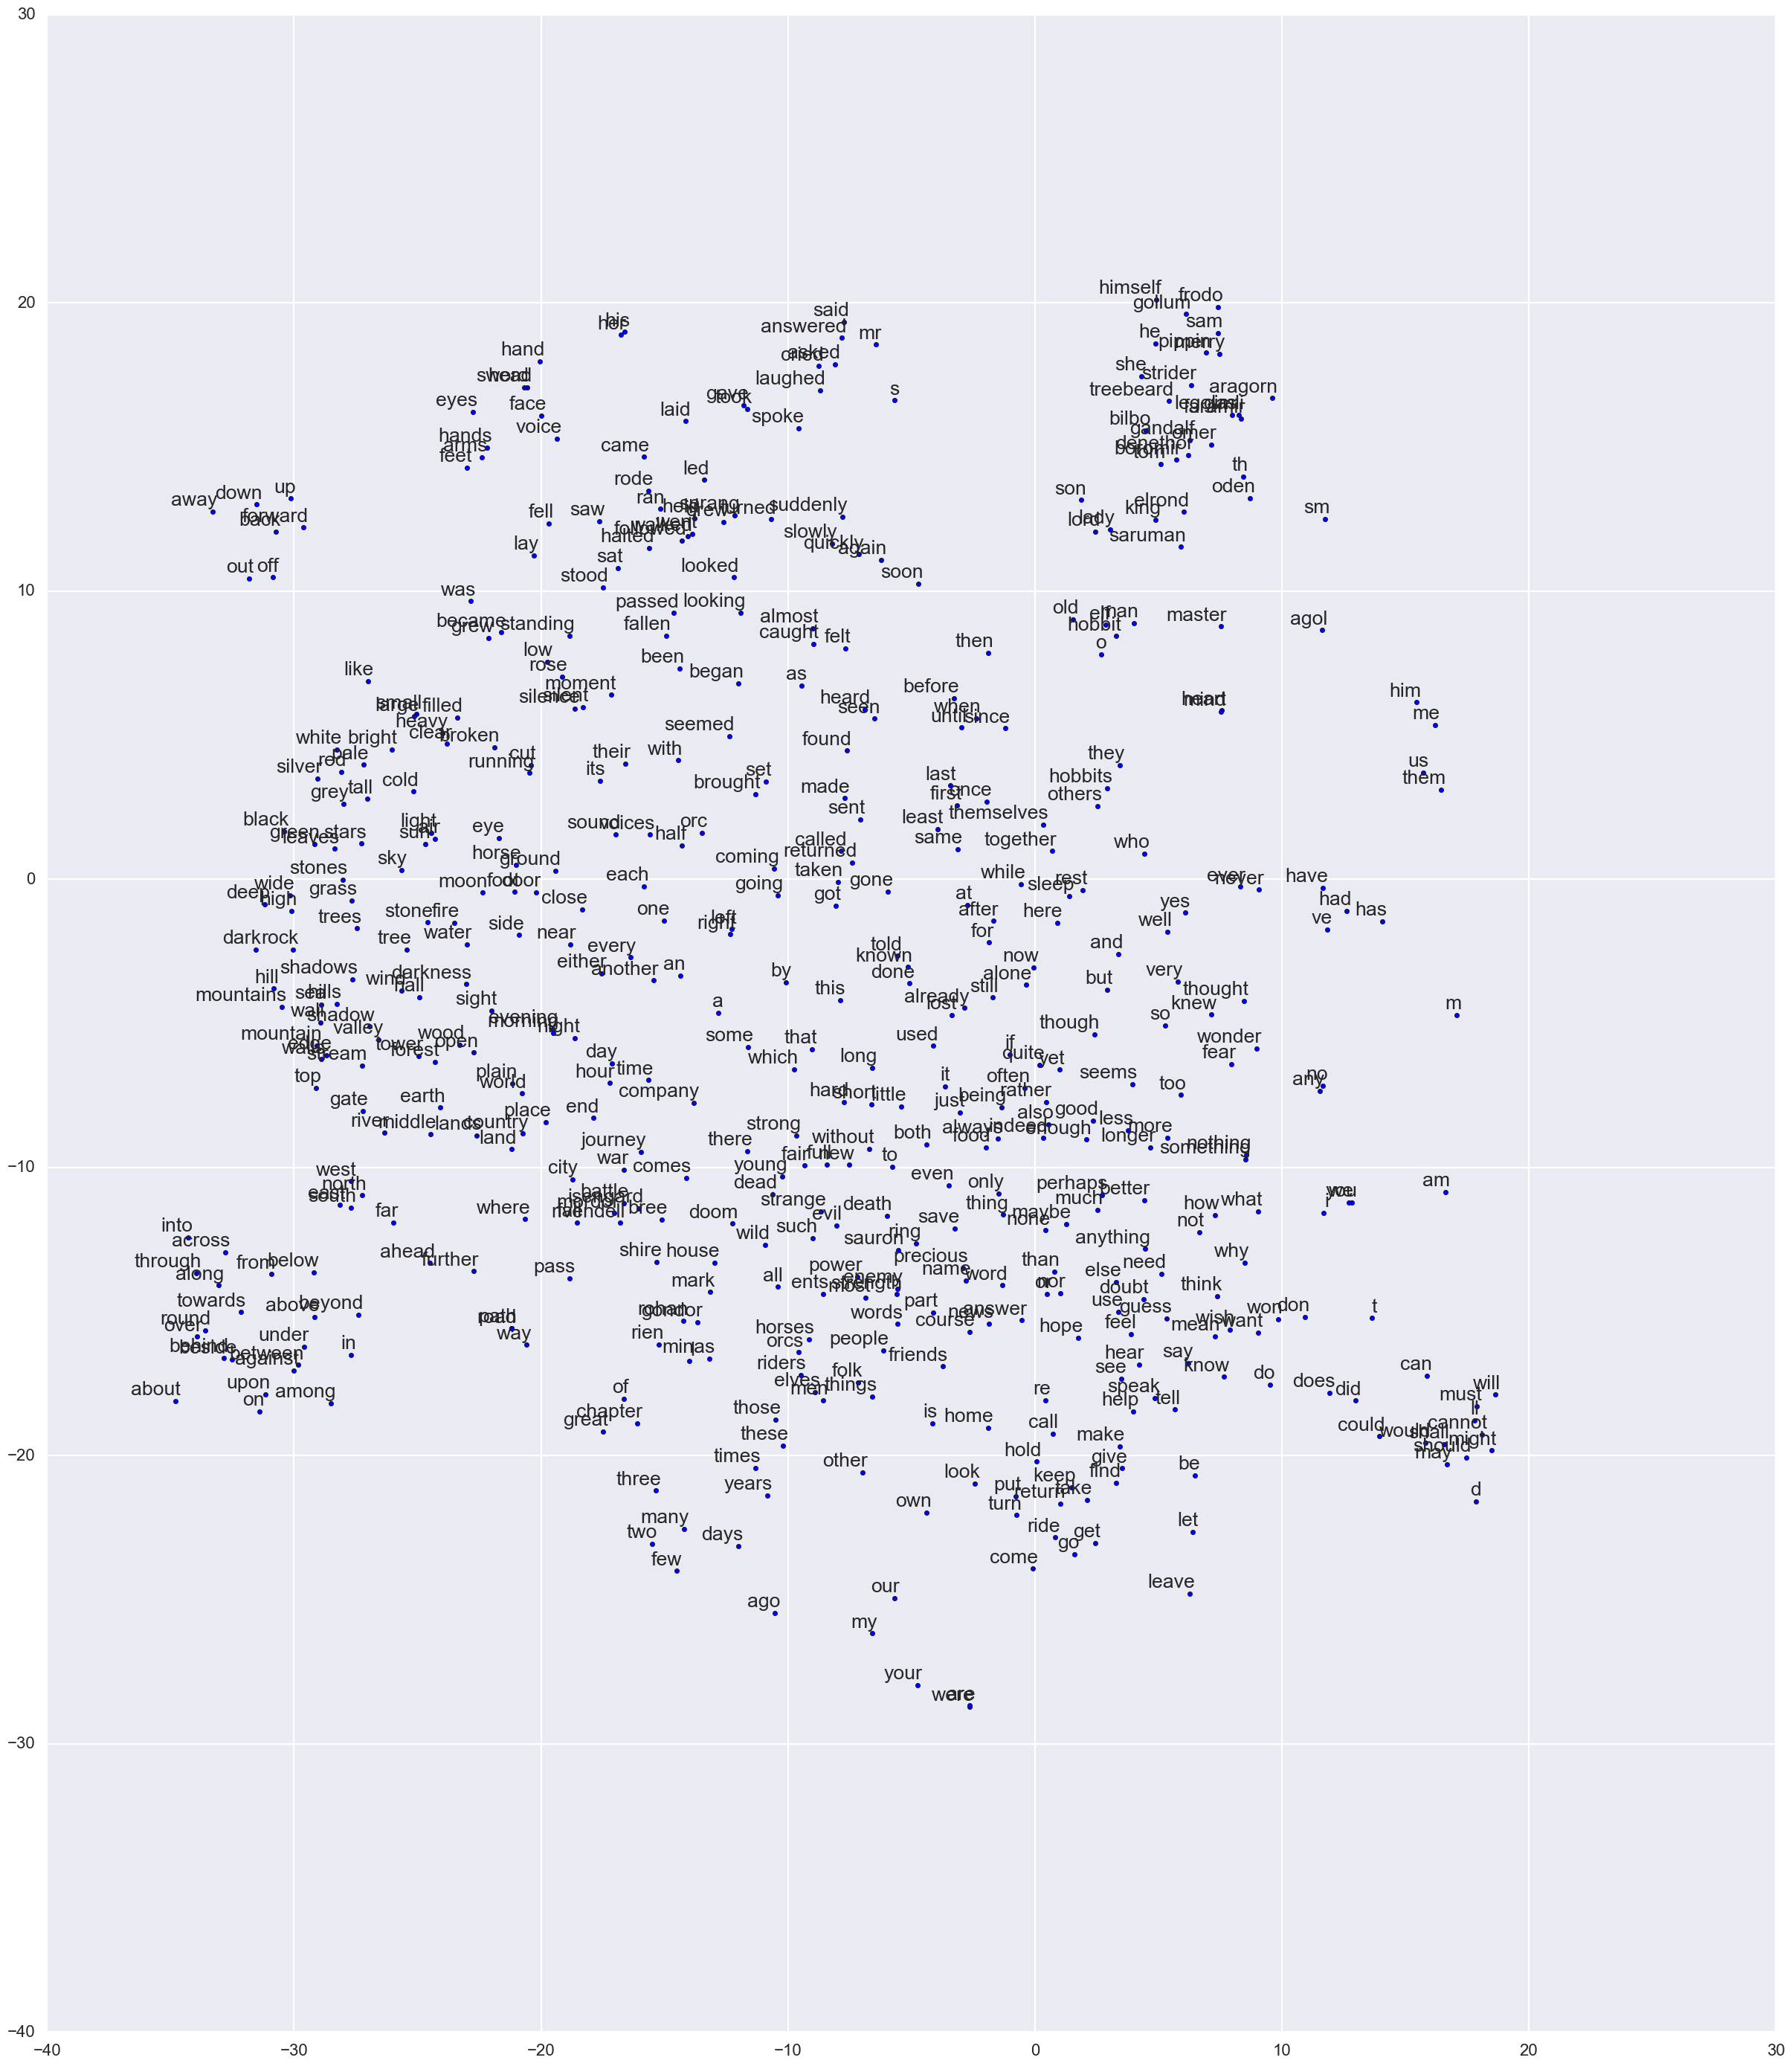

In [253]:
reverse_dictionary_g = {}
for word in thrones2vec.vocab:
    reverse_dictionary_g[thrones2vec.vocab[word].index] = word
    
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(30,35))  # in inches
  for i, label in enumerate(labels):
    try:
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label.decode().encode('utf-8').strip(), xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    except Exception:
        print (label)
  pylab.show()

words = [reverse_dictionary_g[i] for i in range(1, num_points+1)]
plot(all_word_vectors_matrix_2d, words)

In [235]:
def get_similar_words(word_from):
    valid_word = thrones2vec.vocab[word_from].index
#     valid_word = reverse_dictionary_g[word_from]
    similarity = np.dot(all_word_vectors_matrix[valid_word, np.newaxis] ,all_word_vectors_matrix.T)
    import pdb
#     pdb.set_trace()
    top_k = 8 # number of nearest neighbors
    nearest = (similarity[0, :]).argsort()[1:top_k+1]
    log = 'Nearest to %s:' % reverse_dictionary_g[valid_word]
    for k in range(top_k):
      close_word = reverse_dictionary_g[nearest[k]]
      log = '%s %s,' % (log, close_word)
    print(log)


In [236]:
get_similar_words('frodo')

Nearest to frodo: render, unafraid, judges, encourage, am, belief, comrade, sallow,


In [229]:
thrones2vec.most_similar("frodo")


[(u'sam', 0.9112100005149841),
 (u'gollum', 0.9101736545562744),
 (u'pippin', 0.8968303203582764),
 (u'strider', 0.8899877667427063),
 (u'treebeard', 0.8888029456138611),
 (u'faramir', 0.8766719698905945),
 (u'gandalf', 0.8674379587173462),
 (u'merry', 0.8654664158821106),
 (u'beregond', 0.8609415292739868),
 (u'bilbo', 0.8538567423820496)]

In [189]:
points.head(10)a

,word,x,y
0,realms,-0.776945,-4.703391
1,foul,4.522777,-0.709199
2,four,5.721520,0.751918
3,woods,5.655951,6.832217
4,hanging,3.779790,6.381343
5,Until,-2.499913,-4.708523
6,marching,2.787396,6.731387
7,wizardry,2.250756,-0.926311
8,sunlit,3.230478,4.767634
9,Ronald,-1.166075,-1.936974


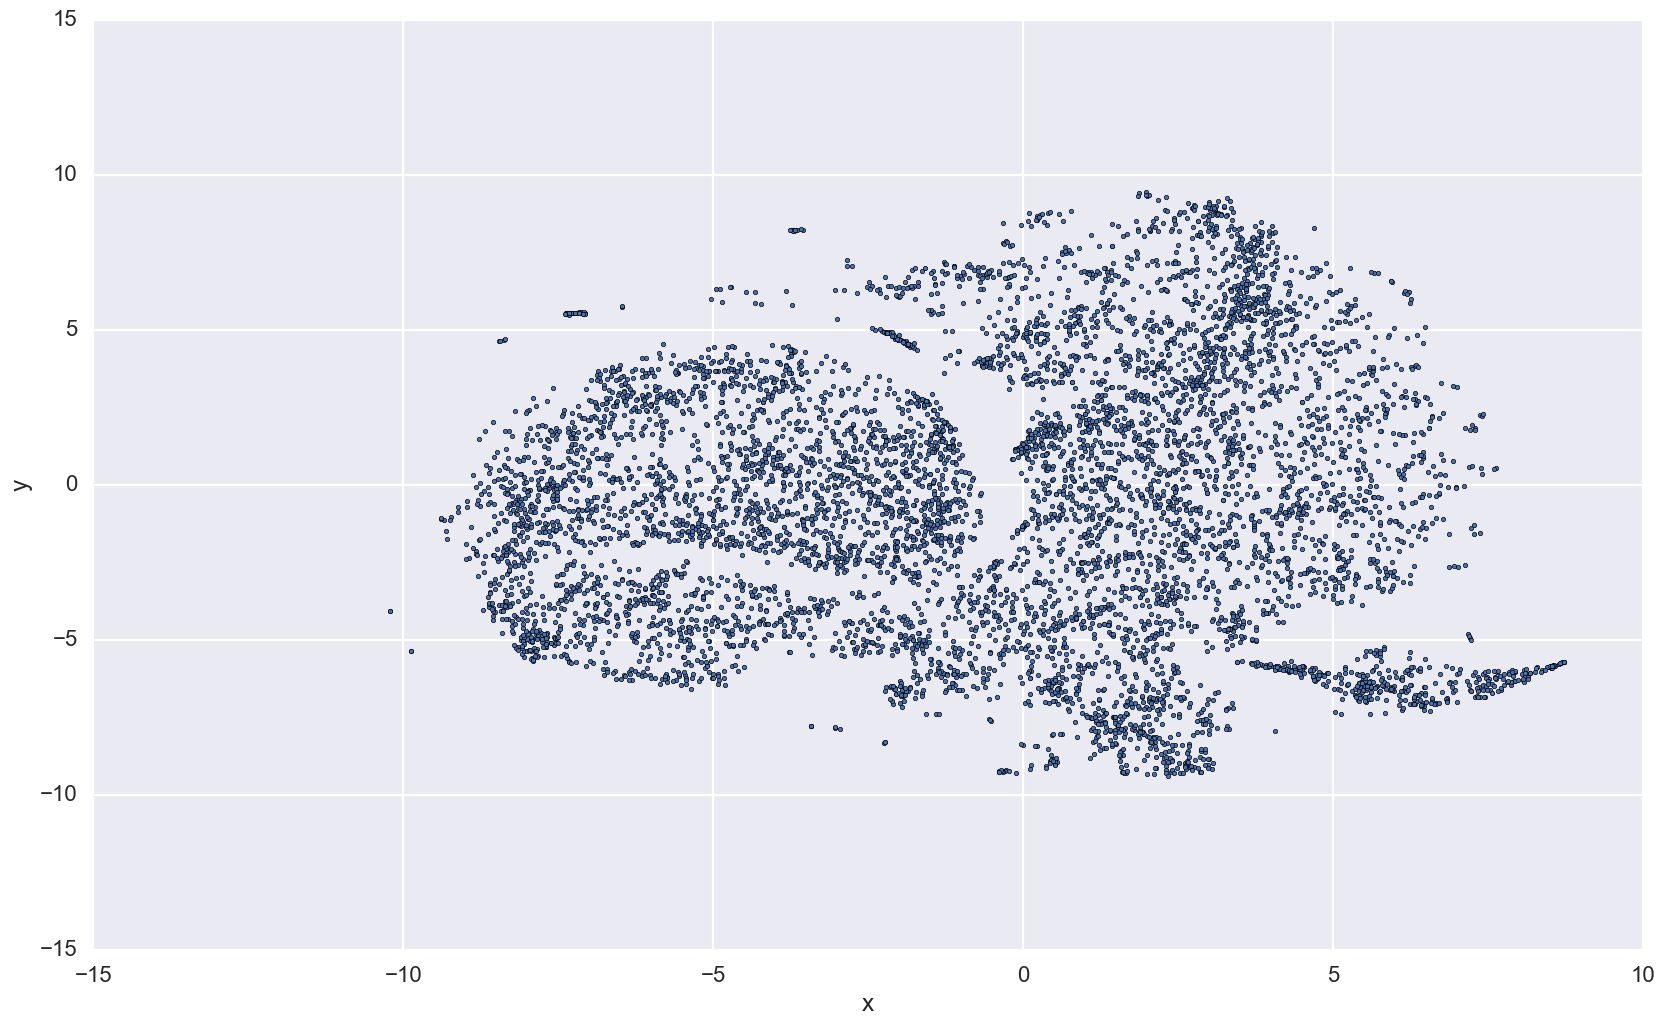

In [237]:

sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [249]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x, point.y , point.word, fontsize=11)

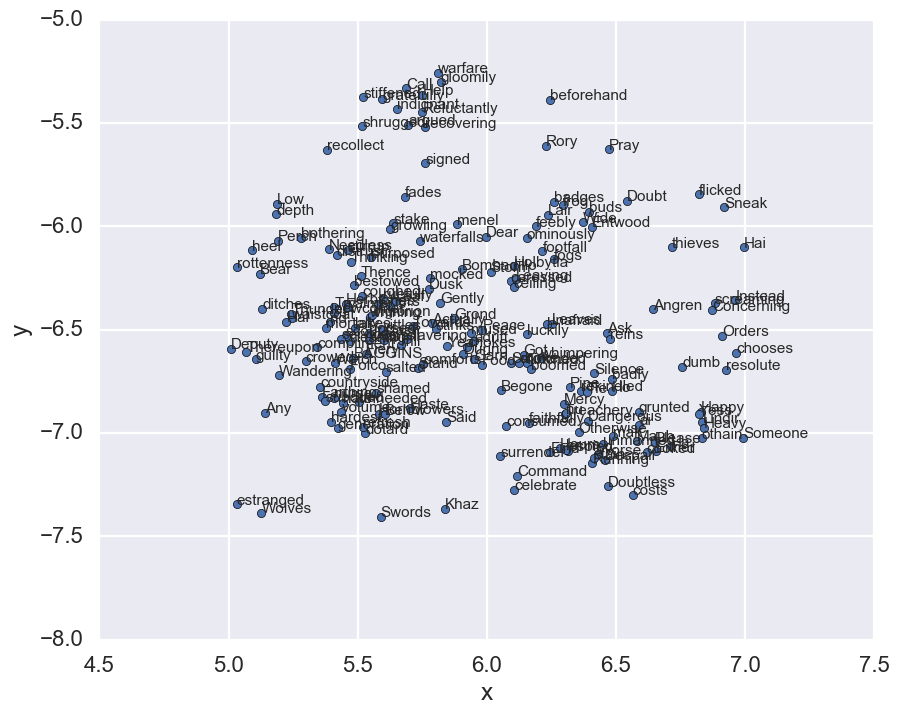

In [251]:
plot_region(x_bounds=(5, 7), y_bounds=(-10, -5))


In [244]:
#plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))


In [245]:
#thrones2vec.most_similar("Stark")


In [ ]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [ ]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
